Vanilla LSTM

In [45]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM
from datetime import datetime
import sys

from read_files import read_files

import matplotlib.pyplot as plt

Index(['Abcdin', 'Falabella', 'Lider', 'Paris', 'Ripley', 'claro', 'entel',
       'movistar', 'wom'],
      dtype='object')


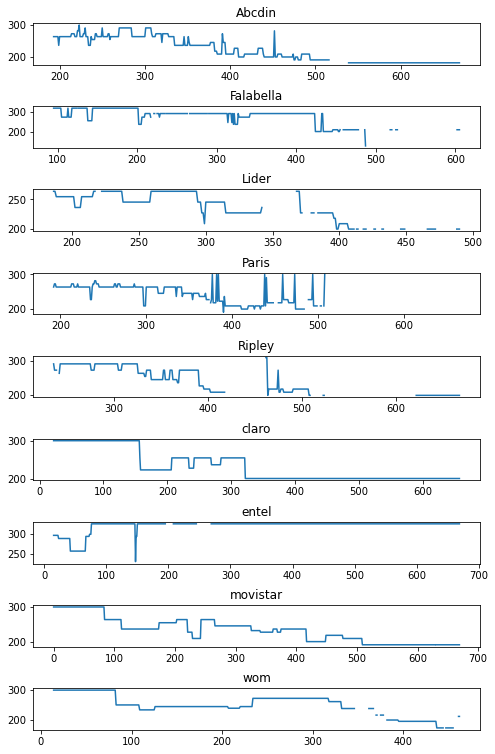

In [46]:
path = "C:/Users/Vasco/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
path = "C:/Users/Vasco Costa/OneDrive - Universidade de Aveiro/Grupo/AIA/" #o teu path
product_group_id = 23 #depende da pasta
time_series_folder = 1 #1,2,3

df_long, df_wide = read_files(path,product_group_id,time_series_folder)
product_information = pd.read_pickle(path+"Data/product_information")
#print(product_information.loc[product_group_id])
#print(df_wide)
print(df_wide.columns)
i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.subplots_adjust(wspace=0.4,
                    hspace=1)
plt.show()

In [47]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

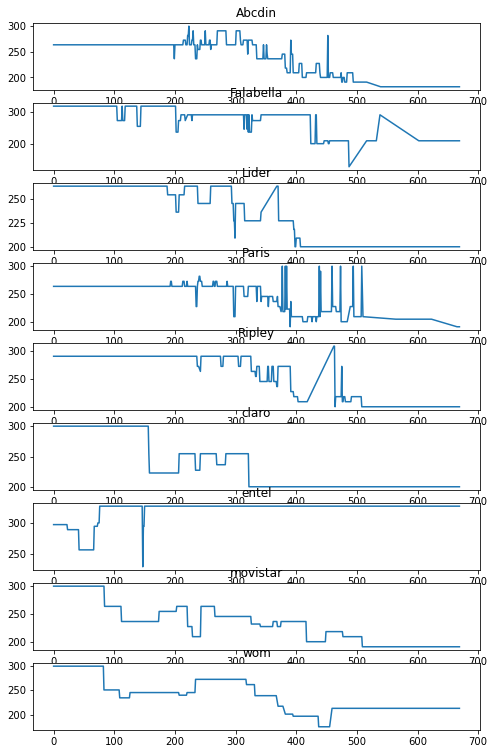

In [48]:
methods= ["linear","time","slinear","quadratic","cubic","barycentric",
        "krogh", "from_derivatives", "pchip", "akima", "cubicspline"]
orders = ["polynomial","spline"]
methods += orders
order = 5

method = methods[1]
#for name in df_wide.columns:
if method in orders:
    df_wide.interpolate(option=method,order=order,inplace=True,limit_direction="both")
else:
    df_wide.interpolate(option=method,inplace=True,limit_direction="both")

i = 1
plt.figure(figsize=(8, 13))
for col in df_wide.columns:
    plt.subplot(len(df_wide.columns), 1, i)
    plt.plot(df_wide[col].values)
    plt.title(col)
    i += 1
plt.show()

In [49]:
company = "Abcdin"
#company = "movistar"
raw_seq = df_wide[company]
n_steps = 7
X, y = split_sequence(raw_seq, n_steps)
percent_train = 0.7
value = int(len(X)*percent_train)
#print(len(X))
X_train = X[:value]
#print(len(X_train))
y_train = y[:value]
X_test = X[value:]
#print(len(X_test))
y_test = y[value:]

Vanilla LSTM

In [50]:
n_features = 1
X = X.reshape((X.shape[0],X.shape[1],n_features))

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Epoch 1/100
7/7 [==============================] - 1s 67ms/step - loss: 64697.2422 - val_loss: 30304.3535
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 53603.3203 - val_loss: 26146.2559
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 45626.3477 - val_loss: 20788.8125
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 32206.4160 - val_loss: 8623.7236
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 10417.6992 - val_loss: 967.7538
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 805.3891 - val_loss: 597.2294
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 938.5414 - val_loss: 93.8022
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 142.2638 - val_loss: 71.1465
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 239.9660 - val_loss: 43.2491
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 153.

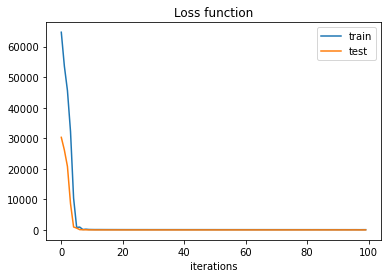

In [51]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), verbose=1, shuffle=False)
#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.show()

7/7 [==============================] - 0s 1ms/step
Test MSE: 17.536


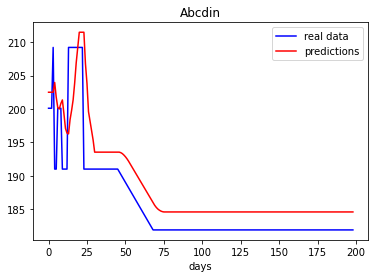

In [52]:
yhat = model.predict(X_test)

mse = mean_squared_error(y_test, yhat)
print('Test MSE: %.3f' % mse)

plt.figure()
plt.plot(y_test,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.title(company)
plt.xlabel("days")
plt.legend()
plt.show()


In [53]:
import math
from keras.callbacks import EarlyStopping

company = "Abcdin"
company = "movistar"
percent_train = 0.7
n_features = 1
dic={}

raw_seq = df_wide[company]
for n_steps in range(1,32):
    X, y = split_sequence(raw_seq, n_steps)
    value = int(len(X)*percent_train)
    X_train = X[:value]
    y_train = y[:value]
    X = X.reshape((X.shape[0],X.shape[1],n_features))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    callback = EarlyStopping(monitor='loss', patience=5)
    history = model.fit(X_train, y_train, epochs=1000, batch_size=72, verbose=1, shuffle=False,callbacks=[callback])
    
    yhat = model.predict(X_train)
    mse = mean_squared_error(y_train, yhat)
    dic[n_steps] = mse

Epoch 1/1000
7/7 [==============================] - 1s 1ms/step - loss: 62018.3672
Epoch 2/1000
7/7 [==============================] - 0s 1ms/step - loss: 60805.2695
Epoch 3/1000
7/7 [==============================] - 0s 1ms/step - loss: 59234.9141
Epoch 4/1000
7/7 [==============================] - 0s 1ms/step - loss: 56829.9844
Epoch 5/1000
7/7 [==============================] - 0s 1ms/step - loss: 54107.8555
Epoch 6/1000
7/7 [==============================] - 0s 1ms/step - loss: 52438.9727
Epoch 7/1000
7/7 [==============================] - 0s 1ms/step - loss: 51118.4648
Epoch 8/1000
7/7 [==============================] - 0s 1ms/step - loss: 49454.5273
Epoch 9/1000
7/7 [==============================] - 0s 1ms/step - loss: 46467.4922
Epoch 10/1000
7/7 [==============================] - 0s 1ms/step - loss: 43735.1211
Epoch 11/1000
7/7 [==============================] - 0s 1ms/step - loss: 41804.8164
Epoch 12/1000
7/7 [==============================] - 0s 1ms/step - loss: 40042.4961
E

In [54]:
n_steps_best = min(dic, key=dic.get)
X, y = split_sequence(raw_seq, n_steps_best)
value = int(len(X)*percent_train)
X_train = X[:value]
y_train = y[:value]
X_test = X[value:]
y_test = y[value:]
X = X.reshape((X.shape[0],X.shape[1],n_features))
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_best, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
callback = EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, y_train, epochs=10000, batch_size=72, validation_data=(X_test, y_test), verbose=1, shuffle=False,callbacks=[callback])

Epoch 1/10000
7/7 [==============================] - 1s 35ms/step - loss: 65853.2969 - val_loss: 38887.0469
Epoch 2/10000
7/7 [==============================] - 0s 4ms/step - loss: 63491.3711 - val_loss: 37461.5234
Epoch 3/10000
7/7 [==============================] - 0s 4ms/step - loss: 61144.6641 - val_loss: 35897.7305
Epoch 4/10000
7/7 [==============================] - 0s 4ms/step - loss: 58444.4609 - val_loss: 33913.3398
Epoch 5/10000
7/7 [==============================] - 0s 4ms/step - loss: 54725.2539 - val_loss: 31192.2715
Epoch 6/10000
7/7 [==============================] - 0s 4ms/step - loss: 49733.4297 - val_loss: 28230.8633
Epoch 7/10000
7/7 [==============================] - 0s 5ms/step - loss: 44840.6484 - val_loss: 25479.7754
Epoch 8/10000
7/7 [==============================] - 0s 4ms/step - loss: 40442.6328 - val_loss: 23190.4746
Epoch 9/10000
7/7 [==============================] - 0s 4ms/step - loss: 36974.0391 - val_loss: 20902.2754
Epoch 10/10000
7/7 [================

1
15/15 [==============================] - 0s 643us/step
train
MAE  :  -0.003761254074130899
MSE  :  20.427414532985974
NRMSE:  0.018136179184977303
test
7/7 [==============================] - 0s 667us/step
MAE  :  -0.21358936629236971
MSE  :  2.121358988762319
NRMSE:  0.0074690116081309954


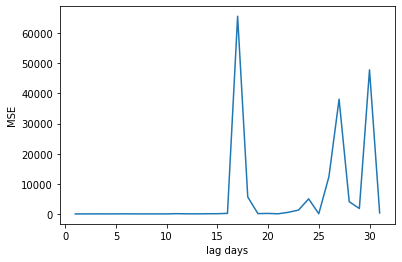

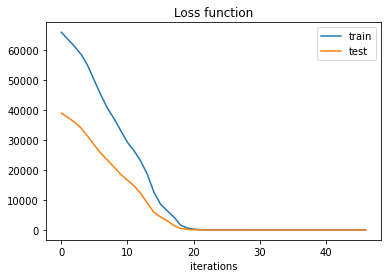

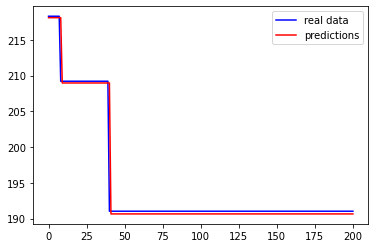

In [55]:
import statistics
print(n_steps_best)
yhat = model.predict(X_train)
yhat = [item for sublist in yhat for item in sublist]
print("train")
print("MAE  : ",sum(yhat - y_train)/len(y_train))
#MSE
print("MSE  : ",sum((yhat - y_train)**2)/len(y_train))
#NRMSE
print("NRMSE: ",math.sqrt(sum((yhat - y_train)**2)/len(y_train))/(statistics.mean(y_train)) )
print("test")
#para o teste
yhat = model.predict(X_test)
yhat = [item for sublist in yhat for item in sublist]
#MAE
print("MAE  : ",sum(yhat - y_test)/len(y_test))
#MSE
print("MSE  : ",sum((yhat - y_test)**2)/len(y_test))
#NRMSE
print("NRMSE: ",math.sqrt(sum((yhat - y_test)**2)/len(y_test))/(statistics.mean(y_test)) )

plt.plot(dic.keys(),dic.values())
plt.ylabel("MSE")
plt.xlabel("lag days")
plt.savefig("lstm_vanilla_"+company+"_lag.png")
plt.show()

#  print history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss function')
plt.legend(['train', 'test'])
plt.xlabel('iterations')
plt.savefig("lstm_vanilla_"+company+"_loss.png")
plt.show()

plt.figure()
plt.plot(y_test,color='b', label='real data')
plt.plot(yhat,color='r', label='predictions')
plt.legend()
plt.savefig("lstm_vanilla_"+company+"_test.png")
plt.show()